<a href="https://www.kaggle.com/mishki/time-series-demand-forecast-arma-prophet?scriptVersionId=90274358" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**Quick intro**

This notebook is about demand prediction on a simple time series dataset. I think it's a good precursor to a crypto or stocks prediction problem later on.

I have anoher notebook / tutorial that takes one through the <a href="https://www.kaggle.com/mishki/tutorial-time-series-exploration-crypto-price">**basics of working with time series**</a>, so here I skip the basic theory.

What this notebook is:  
- a good starting point for working with classic time series prediction models
- a cookbook we can use for exploration of what type of models may fit when starting to work with a new dataset

What this notebook is not:
- it's not meant for advanced practitioners of time series forecast - unless you want to revisit some concepts.  

### Contents

[1. Quick overview](#1.-Quick-overview)  
[2. Dataset exploration](#2.-Dataset-exploration)  
[3. Feature engineering](#3.-Feature-engineering)  # to do later  
[4. Model building and evaluation](#4.-Model-building-and-evaluation)    
    [4.1 Smoothing-methods](#4.1-Smoothing-methods)  
    [4.2 Prophet & Neural Prophet](#4.2-Prophet-&-Neural-Prophet)  
    [4.3 ARMA & versions](#4.3-ARMA-&-versions)  

In [1]:
import pandas as pd
import numpy as np
import os 
import time

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 

from datetime import datetime

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from fbprophet import Prophet
from fbprophet.plot import plot_yearly, add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation, performance_metrics

from sklearn.metrics import mean_absolute_error

import itertools

In [2]:
img_w = 12
img_h = 6
        
# by default, figure size is very small; we set a larger value as default one
plt.rcParams.update({'figure.figsize': (img_w, img_h)})    

# 1. Quick overview

This dataset was made available on Kaggle as part of the <a href='https://www.kaggle.com/c/demand-forecasting-kernels-only/overview'>Store Item Demand Forecasting Challenge</a>. 

You are given 5 years of store-item sales data, and asked to predict 3 months of sales for 50 different items at 10 different stores.

# 2. Dataset exploration

Let's look inside the data folder that comes with this competition.

In [3]:
data_folder = "../input/demand-forecasting-kernels-only/"
!ls $data_folder

sample_submission.csv  test.csv  train.csv


Reads the train and test datasets

In [4]:
train_df = pd.read_csv(os.path.join(data_folder, 'train.csv'))
test_df = pd.read_csv(os.path.join(data_folder, 'test.csv'))

First: what is the structure of the data (that is, what fields do we have in the two tables provided)

**Training set exploration**

In [5]:
train_df.head(5)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


`date` - the data seems to have a daily resolution  
`store` - unique identifier of the store from which the data comes from; we know from the competition description that there are 50 stores  
`item` - unique identified of an item  
`sales` - absolute number of items sold in the time resolution (the respective day)  

In [6]:
train_df.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


- There are 913k entries in the training set  
- store id goes from 1 to 10  
- item id goes from 1 to 50  
- sales ranges from 0 to 231 (therefore, we draw the conclusion that no sale for the day is reported as 0, not as nan/missing value)

**Check for missing values**  

The easiest test is to see if there are any null values in any of the cells of this dataframe.  

We see below that this dataset contains no null values.

In [7]:
train_df.isna().sum()

date     0
store    0
item     0
sales    0
dtype: int64

The next question that comes to mind if whether we can have a whole day of data missing for any (store, item) combination.  

An easy way to test this is to count the number of entries for each (store, item) combination.

In [8]:
train_df.groupby(['store', 'item']).count().sales.value_counts()

1826    500
Name: sales, dtype: int64

The results above tells us that:  
- we have 500 different (store, item) pairs (which is correct, given our 10 stores x 50 items problem description)  
- each pair has 1826 entries. So, either each of them misses the same amount of data (highly unlikely) or they all have no missing entries (no missing day). I assume the latter, due to its higher probability. 

Let's make the `date` column the index of this dataframe. Seems to make more sense and will facilitate some operations (plotting for example or finding gaps in consecutive rows).

In [9]:
train_df.dtypes

date     object
store     int64
item      int64
sales     int64
dtype: object

As expected (due to reading from CSV with default settings), the date is a string. Let's make it a datetime. 

In [10]:
train_df['date'] = pd.to_datetime(train_df['date'])

In [11]:
train_df.set_index('date', inplace = True)

Training data time interval  

We have 5 full years of data, indeed: from **Jan 1st 2013** to **Dec 31st 2017**. 

In [12]:
train_df.iloc[0], train_df.iloc[-1]

(store     1
 item      1
 sales    13
 Name: 2013-01-01 00:00:00, dtype: int64,
 store    10
 item     50
 sales    82
 Name: 2017-12-31 00:00:00, dtype: int64)

**Test set exploration**

In [13]:
test_df.head(5)

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


We have the `store` and `item` variables, as expected.  
`id` is probably some unique identifier of each entry in the test_df table (for who knows what reasons) - we check this assumption below.

In [14]:
test_df.id.nunique(), len(test_df)

(45000, 45000)

The structure of the test file is most likely just a convenience. We should add a `sales` column containing our prediction before submitting to Kaggle for checkin against their actual test data.

**Dilemma**  

We saw earlier that there are 500 (store, item) pairs for which we have data and for which we need to make a predictions.  

How to approach this problem ? The most obvious solution it to fit a model to each (store, item). That would be 500 models 😱  

To make life easier, I'll start with a single (store, item) pair and find the best model for it. And I'll think about the other 499 later.  

All analysis from now on will focus on data from a single pair.

In [15]:
pair_df = train_df[(train_df.store==1) & (train_df.item==1)].copy(deep=True) 

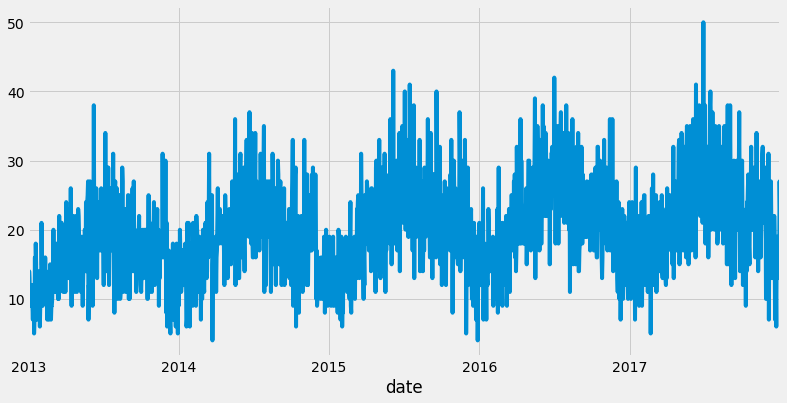

In [16]:
pair_df.sales.plot(); 

# 4. Model building and evaluation

Remember the structural decomposition of time series data:  
`Xt = Tt + St + Ct + Err`   
Xt = the value at time t  
Tt = the trend; a long term general drection  
St = seasonal component; something that repeats at known intervals (i.e. annually, monthly, weekly patterns)  
Ct = cyclical component; a pattern that does not occurr at predictable time points (i.e. a bull market)  
Err = something extra, ideally random, that cannot be modeled (we can call if error term)    

There is also one extra component not mentioned above: the level (overall average value).  

There is:  
- an obvious non zero level in the plot above  
- no discernable trend (no upward going or downward going movement on the long term)  
- a recurrent short term pattern (seasonality)  

Let's do a seasonal decomposition to see it more clearly.

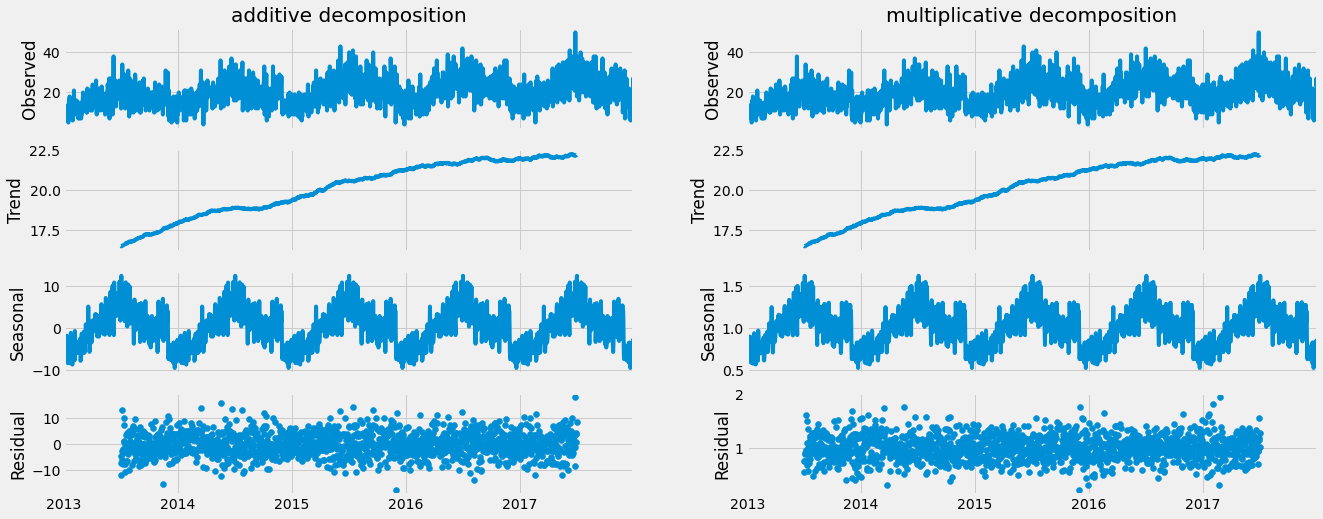

In [17]:
# perform seasonal decomposition
# we have daily data and from the plot above we see that one season lasts approx 1 year ~ 365 days 

fig, axes = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(20, 8))

for i,model in enumerate(['additive', 'multiplicative']):
    
    decomposition = sm.tsa.seasonal_decompose(pair_df.sales,period = 365, model=model) 
    decomposition.observed.plot(ax=axes[0,i], legend=False)
    
    axes[0,i].set_title(model + ' decomposition')
    
    axes[0,i].set_ylabel('Observed')
    decomposition.trend.plot(ax=axes[1,i], legend=False)
    axes[1,i].set_ylabel('Trend')
    decomposition.seasonal.plot(ax=axes[2,i], legend=False)
    axes[2,i].set_ylabel('Seasonal')
    #decomposition.resid.plot(ax=axes[3,i], legend=False)
    axes[3,i].scatter(np.array(decomposition.resid.index), decomposition.resid)
    axes[3,i].set_ylabel('Residual')
plt.show()


It looks like seasonal decomposition identified a trend too, in both cases.

The additive decomposition:  
- the seasonal component is quite obvious.   
- the residuals are larger than in the case of multiplicative decomp.

The additive decomposition:  
- the seasonal component is small
- the residuals are small too

We proceed with the classic ADF test for stationarity to confirm what looks pretty obvious.

In [18]:
result = adfuller(pair_df.sales)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.157671
p-value: 0.022569
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568



The augmented Dickey-Fuller test: the null hypothesis is that the series is non-stationary. If we get a small enough p, we reject the null hypothesis and conclude tha the series is stationary. 

The results above suggests that we reject the Null hypothesis and assume the series is stationary. This is unexpected.  

When a time series is stationary, it can be easier to model. Some statistical modeling methods require the time series to be stationary to be effective. According to the ADF result, we need not worry about this in this case. 

In [19]:
len(pair_df)

1826

In [20]:
result = adfuller(pair_df[:1700].sales)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.807998
p-value: 0.057140
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


It seems like the ADF test is significant only when we consider the whole amount of data, but if we reduce it and ignore the last 4-5 months of data, the test result indicated non-stationary data.   

From this and from the look of the seasonal decomposition plot, I think it's safer to assumer the data is non-stationary and adapt models to this assumption.

# 4.1 Smoothing methods

Smoothing methods seem to be the oldest approach to time series modeling. As per testimonials of seasoned Time Series Data Scientists, some of them still give decent results for some datasets. So I'll take a look at a few of them too.

These are variations around the idea that a future observation can be modeled as a weighted average of past observations, with the weights decaying exponentially as the observations get older.   

According to <a href='https://otexts.com/fpp3/'>Forecasting: Principles and Practice (3rd ed)</a>, by Rob J Hyndman and George Athanasopoulos, here is a classification of popular exponential smoothing methods: 
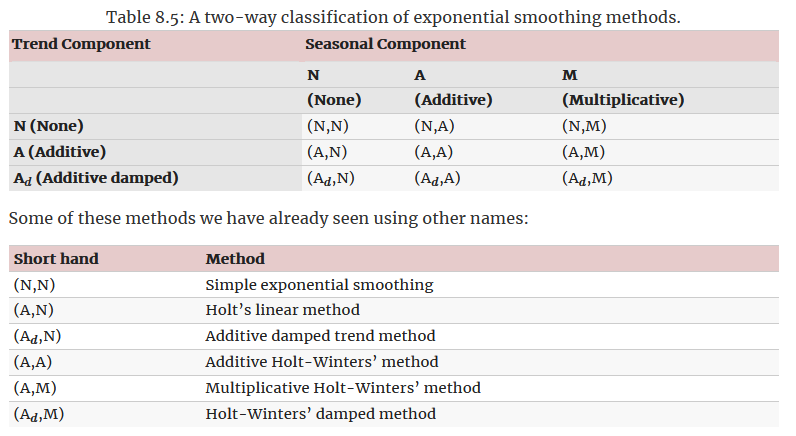

I found <a href='https://otexts.com/fpp3/expsmooth.html'>this</a> to be a good resource for learning about exponential smoothing.

I will try 3 of those on this dataset (because I'm rather sure they will not be enough, so no need to try them all, I assume):  

    (N,N) - aka the simple exponential smoothing
    (A,N) - aka double exponential smoothing or Holt's linear trend method
    (A,A) - aka triple exponential smoothing or additive Holt-Winters' method


**Simple exponential smoothing**

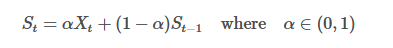  

The out ouf sample predictions follow this formula:  

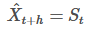
that is, future values are predicted as the last known computation for which we had data (so it's gonna be a flat line).

- also known as Brown method  
- it has one parameter: alpha; I will try a few values and see the effect  
- this method basically predicts the level component (from the structural decomposition seen earlier).

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


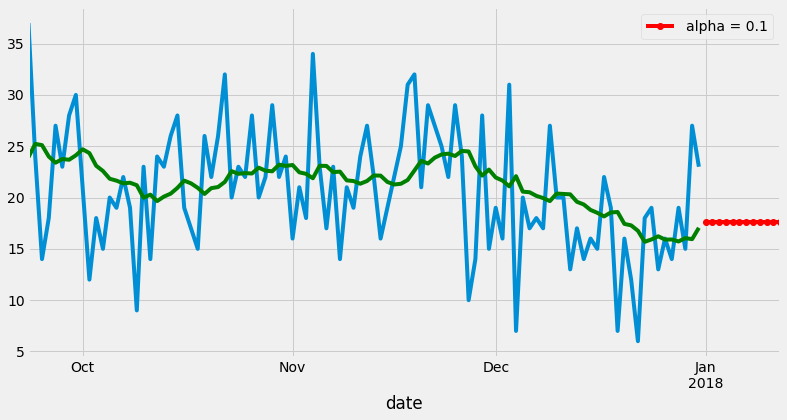

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


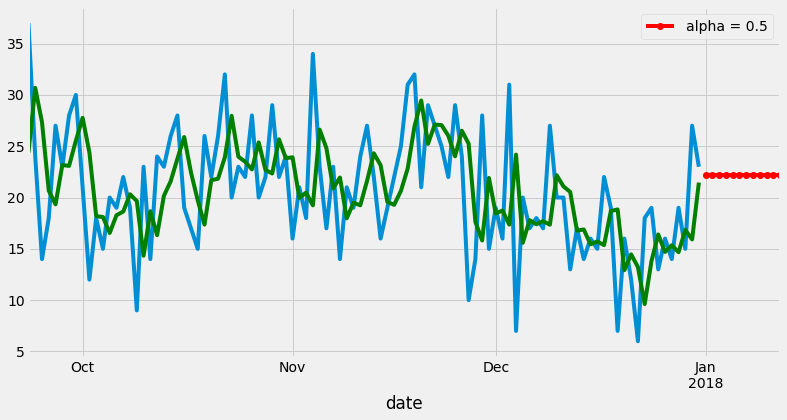

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


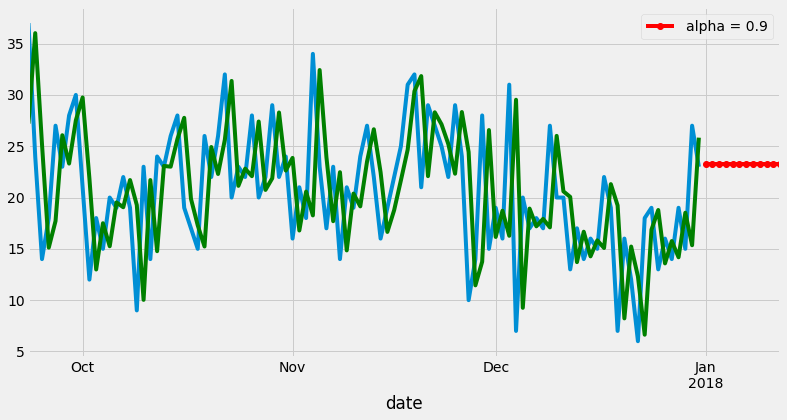

In [21]:
for alpha_sm in [0.1, 0.5, 0.9]:
    df = pair_df.sales
    
    fit1 = SimpleExpSmoothing(df).fit(smoothing_level = alpha_sm  ,optimized=False)
    fcast1 = fit1.forecast(12).rename('alpha = ' + str(alpha_sm))
    
    df[-100:].plot.line()
    fcast1.plot(marker='o', color='red', legend=True)
    fit1.fittedvalues[-100:].plot(  color='green')
    
    plt.show()

Observations:  
- the lower the alpha, the more atenuated the prediction (as an average of the previous values, it cuts more into the volatility), the higher the alpha the closer the prediction is to the real volatily of previous data points  
- the out of sample predictions (the last 12 predictions) are flat line.

**Double exponential smoothing**  

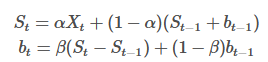

S1=X1, b1=X1−X0 and α,β∈(0,1)

- this method basically predicts the level and the trend from the structural decomposition seen earlier  
- this model has 2 parameters: alpha and beta  

The out of sample forecast is:  
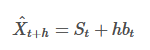

Below I compare simple and double exponential smoothing.  
I use the alpha = 0.5 value, which led to moderate attenuation and the same dataset as before. I will only plot the last 100 data points (for visibility reasons).

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


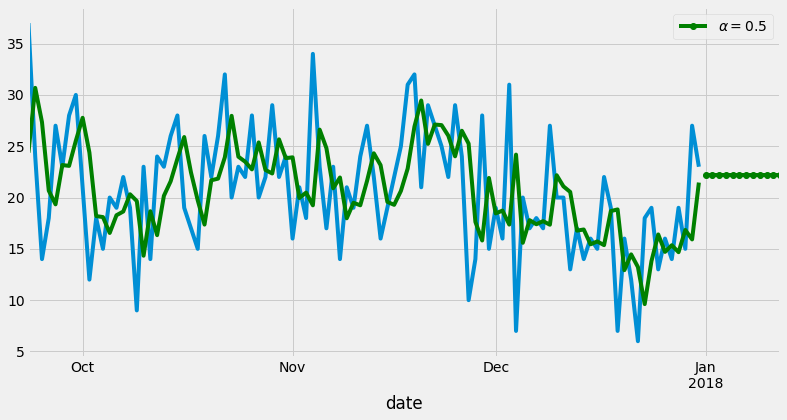

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  del sys.path[0]


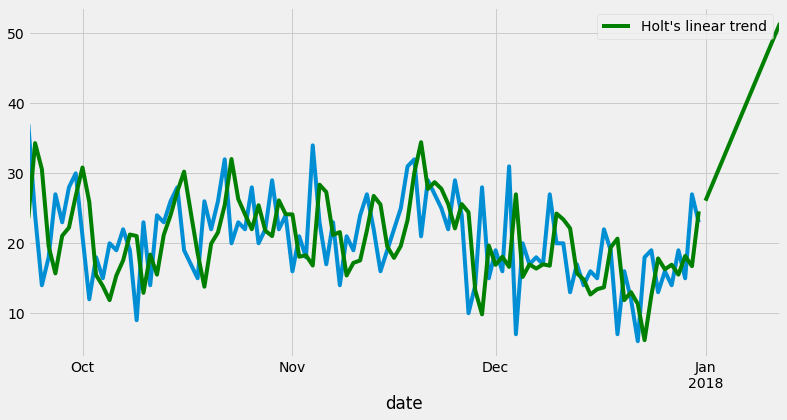

In [22]:
alpha = 0.5

fit1 = SimpleExpSmoothing(df).fit(smoothing_level=alpha, optimized=False)
fcast1 = fit1.forecast(12).rename(r'$\alpha=0.5$')  # forecasting only 12 days (since it's a flat prediction anyway)
fcast1.plot(marker='o', color='green', legend=True) # plot forecast

df[-100:].plot.line()
fit1.fittedvalues[-100:].plot(  color='green')

plt.show()


fit1 = Holt(df).fit(smoothing_level=0.5, smoothing_slope=0.5, optimized=False)
fcast1 = fit1.forecast(12).rename("Holt's linear trend")  # forecasting only 12 days (enough to get an idea of what predictions look like)
fcast1.plot(color='green', legend=True)

df[-100:].plot.line()
fit1.fittedvalues[-100:].plot(color='green')


plt.show()

Observations:
- in sample predictions look like a shadow of the past data (a lagged version) for both methods, but more attentuated in the first method
- out of sample predictions stop being a flat line for the double exponential, but exaggerate the short term trend

**Triple exponential smoothing**  

It's defined as:  
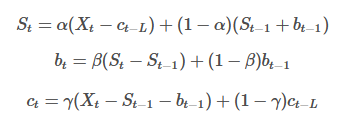

And out of sample predictions will be:  
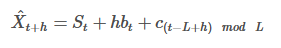

I will use the same data as before and:  
- predict the following 1 year worth of data this time (so we can see a whole season of predicted data, because now it makes sense to look at it since it's not going to be flat or a straight line as earlier)  
- plot approximately 2 years of historical data (to visually compare predictions against)  

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


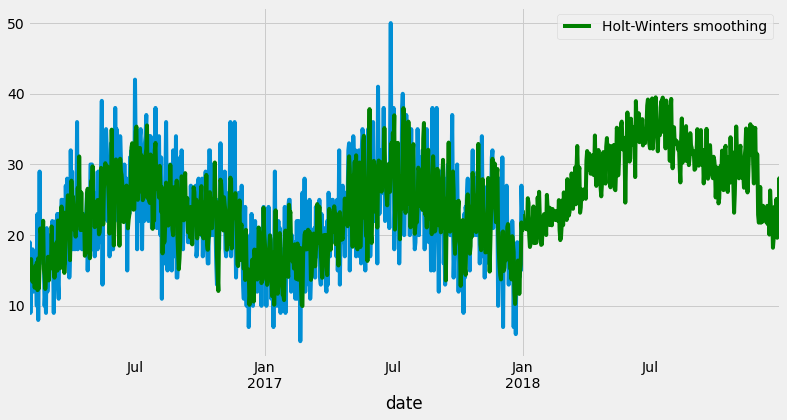

In [23]:
alpha = 0.5
seasonal_periods = 365

fit1 = ExponentialSmoothing(df, seasonal_periods=seasonal_periods, trend='add', seasonal='add', use_boxcox=True)
fit1 = fit1.fit(smoothing_level=0.5)
fit1.forecast(365).rename("Holt-Winters smoothing").plot(color='green', legend=True)

df[-700:].plot.line()
fit1.fittedvalues[-700:].plot(color='green')

plt.show()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


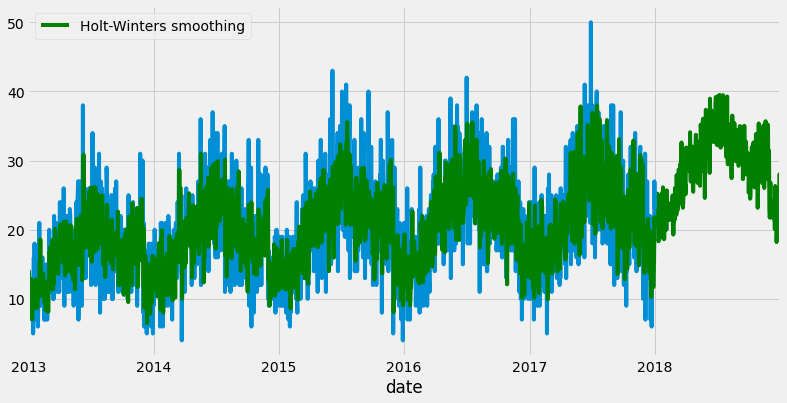

In [24]:
alpha = 0.5
seasonal_periods = 365

fit1 = ExponentialSmoothing(df, seasonal_periods=seasonal_periods, trend='add', seasonal='add', use_boxcox=True)
fit1 = fit1.fit(smoothing_level=0.5)
fit1.forecast(365).rename("Holt-Winters smoothing").plot(color='green', legend=True)

df.plot.line()
fit1.fittedvalues.plot(color='green')

plt.show()

This method is clearly a candidate model for which to actually perform a train-test split and compute metrics.  

Remember from earlier seasonal decomposition plots (at the start of section 4), that it was not clear if additive or multiplicative decomposition is better. So I would try both and compare metrics.

**Train-test split**

In [25]:
print(f'Cutoff point for a 70-30 train-test split: {0.3 * len(pair_df)}')

Cutoff point for a 70-30 train-test split: 547.8


In [26]:
pair_df.iloc[-547]

store     1
item      1
sales    35
Name: 2016-07-03 00:00:00, dtype: int64

In [27]:
cutoff_date = '2016-07-03'

X_train, X_eval = pair_df.loc[pair_df.index <= cutoff_date].sales, pair_df.loc[pair_df.index > cutoff_date].sales

print(X_train.shape), print(X_eval.shape)

(1280,)
(546,)


(None, None)

**Model evaluation**

Use the same smoothing parameters and season length.  

Remember we have daily data, so one year season will be 365 data points long (at least 3 out of 4 years).

In [28]:
alpha = 0.5
seasonal_periods = 365

In [29]:
fit1 = ExponentialSmoothing(X_train, seasonal_periods=seasonal_periods, trend='add', seasonal='add', use_boxcox=True)
fit1 = fit1.fit() # no alpha given; I will let the algorithm find the best alpha

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


**Residuals**

Examine information contained in the model's residuals.  

Start with autocorrelation (ACF). If there is a significant lagged component, it means there is still information left in the residuals, which could be captured by an improved model.  

\# Components sticking outside the blue area are statistically significant  
\# The first component is the current time point; the second component is a measure of the dependency between the current time point and one point back in time; and so on...

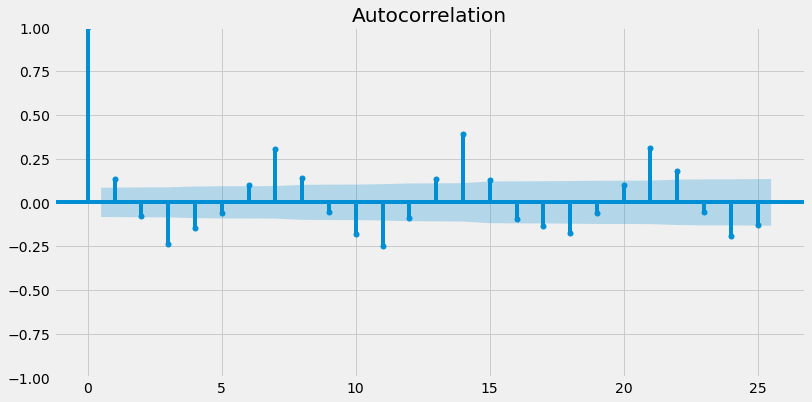

In [30]:
prediction = fit1.forecast(len(X_eval)).copy()

xresiduals = X_eval - prediction
plot_acf(xresiduals, lags = 25)
print()

Partial autocorrelation looks at dependency between the current time point and past values while controlling for the time poins in between.    

Even when the mediation from intermediate time points is taken out of the relationship, there is a significant relationship between the current time point and the ones from 1 and 2 weeks before.  

Conclusion:  
- we saw in the seasonal decomposition an annual seasonality  
- we now see in the residuals of a triple exponential smoothing model a weekly seasonality which was not captured by this model and remained in the residuals (so to speak)

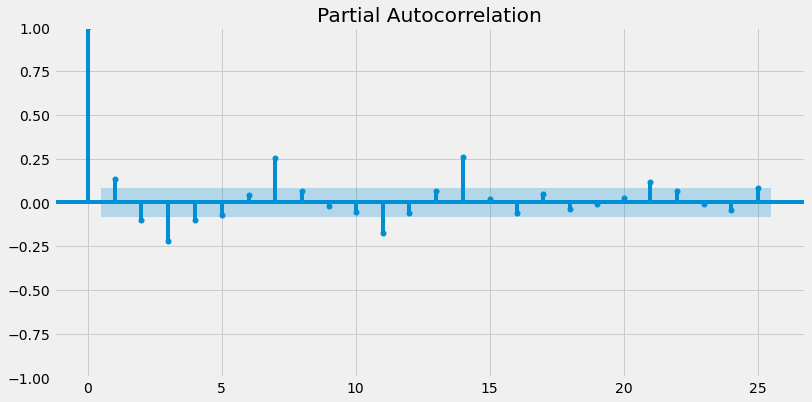

In [31]:
plot_pacf(xresiduals, lags = 25, method='ywm')
print()

**Metrics**

Formal model evaluation: let's check metrics.

In [32]:
y_true = X_eval.values

mae_add = mean_absolute_error(y_true, prediction)

print(f'MAE for triple exponential smoothing model: {mae_add:.3f}')

MAE for triple exponential smoothing model: 5.411


Save it for later, to compare it to Prophet and ARMA.

In [33]:
results_df = pd.DataFrame.from_dict({'method': ['additive'], 'mae': [mae_add]})
results_df.index = ['triple exponential smoothing']

results_df

,method,mae
triple exponential smoothing,additive,5.411132


# 4.2 Prophet & Neural Prophet

The next level, after the classical exponential smoothing methods is Prophet, developed by Facebook.  

Prophet is based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. 

It works best with time series that have strong seasonal effects and several seasons of historical data. 

Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.  

One of its greatest avantages is that it cah handle multiple seasonaliy ocmponents (unlike exponential smoothing), which is something that as we saw earlier, we may need for this dataset.

A very good resource for getting started with Prophet is <a href='https://www.kaggle.com/konradb/ts-1a-smoothing-methods'>this notebook by Konrad Banakewicz</a> and its associated <a href='https://www.youtube.com/watch?v=kAI67Sz92-s&ab_channel=AbhishekThakur'>video lecture here</a>.  

Also, <a href='https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/'>this tutorial</a> by Jason Brownlee.

Preparing the dataset:  
Prophet expects input in a precise format:    
- it must consist of a date column named 'ds' (dataframe index or an actual column)   
- it must contain column 'y' (the actual values to be used for model fitting)

In [34]:
x_train = X_train.reset_index()[['date', 'sales']].rename(columns={"date": "ds", "sales": "y"})

Prophet can be configured through multiple parameters. If none are given, the model will try to infer the best values. Let's try this.  

The fitting function is very verbose. Later I will add code to supress this output.

Initial log joint probability = -30.6342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89       2306.73   0.000765197       165.583   6.652e-06       0.001      153  LS failed, Hessian reset 
      99       2307.23   0.000473468       97.3659      0.3935           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     167       2307.73   0.000647842       129.283   5.867e-06       0.001      287  LS failed, Hessian reset 
     199       2308.22   1.42762e-05       93.4772      0.2982           1      325   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     237       2308.23   1.24152e-07       78.8279           1           1      374   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


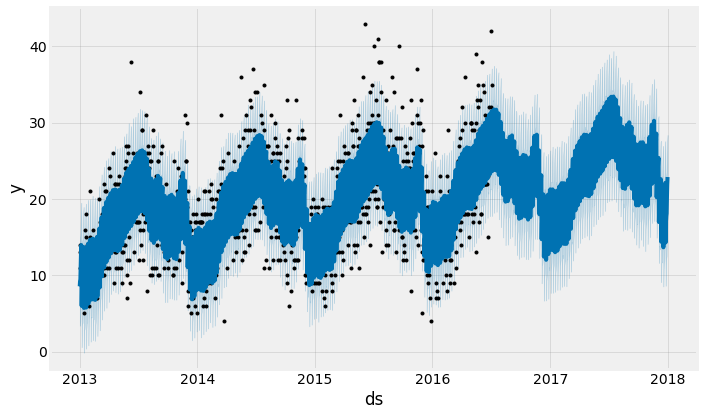

In [35]:
# intantiate a model with default parameters
m_add = Prophet() 

# fit the model
m_add.fit(x_train) 

# get a suitable dataframe that extends into the future a specified number of days
# forecast will contain the prediction for all x_train dates + the prediction for 
#`periods` number of days into the future
future = m_add.make_future_dataframe(periods=len(X_eval)) 

# in-sample predictions as well as out of sample predictions (if periods above was different than 0)
forecast_add = m_add.predict(future)

m_add.plot(forecast_add)

plt.show()

Decorator to supress output (the very verbose table seen in the previous run of Prophet, above).

In [36]:
# from https://stackoverflow.com/questions/11130156/suppress-stdout-stderr-print-from-python-functions
class suppress_stdout_stderr(object):
    '''
    A context manager for doing a "deep suppression" of stdout and stderr in
    Python, i.e. will suppress all print, even if the print originates in a
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).

    '''
    def __init__(self):
        # Open a pair of null files
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        # Save the actual stdout (1) and stderr (2) file descriptors.
        self.save_fds = (os.dup(1), os.dup(2))

    def __enter__(self):
        # Assign the null pointers to stdout and stderr.
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        # Re-assign the real stdout/stderr back to (1) and (2)
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        # Close the null files
        os.close(self.null_fds[0])
        os.close(self.null_fds[1])

Some notes on the plot above:  
- the training data is represented as black dots  
- the forecast is a blue line with upper and lower bounds in a blue shaded area  

The predictions look modest. The actual data shows higher volatility than the model predicts. However, this is similar to what the triple exponential smoothing predicted.  

One aspect that can be improved from the triple smoothing by using Propher is modeling the weekly trend. Remember the residuals form the triple smoothing prediction were showign signs of a weekly dependency ? Because triple smoothing can only model one seasonality. Prophet however models several. To vizualize this feature, I'll use the `plot_components` method.

`Prophet.plot_components` method:  
- by default it will show the trend, yearly seasonality, and weekly seasonality of the time series. 
- if we included holidays, we would see those here, too.  

I didn't have to mention these explicitly. Prophet decided which seasonalities to look for based on the resolution of the dataset.  

If I had hourly data, there woul have been a daily seasonality shown in the following plot too.

In [37]:
from fbprophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m_add, forecast_add)

plot_components_plotly(m_add, forecast_add)


/opt/conda/lib/python3.7/site-packages/plotly/io/_json.py:469: UserWarning:

Discarding nonzero nanoseconds in conversion



**Change points**  

An interesting functionality of Prophet is the estimation of change points. By default, it will try to estimate 25 of these. The number can be adjusted and the points can also be manually provided (useful when domain knolwdge allows for this).  

I want to see the change points estimation in action.

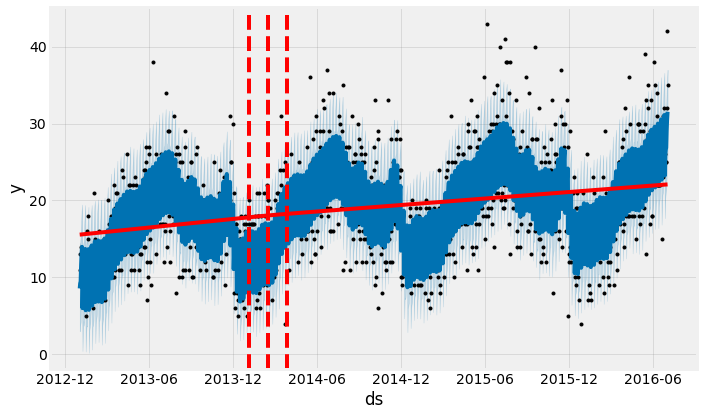

In [38]:
with suppress_stdout_stderr():

    # intantiate a model with default parameters
    m0 = Prophet() 

    # fit the model
    m0.fit(x_train) 

    future = m0.make_future_dataframe(periods=0) 

    forecast = m0.predict(future)

    fig = m0.plot(forecast)
    a = add_changepoints_to_plot(fig.gca(), m0, forecast)

    plt.show()

This looks bad and <a href='https://facebook.github.io/prophet/docs/uncertainty_intervals.html'>Prophet</a> documentiation on uncertainty intervals clears this out a bit. Change points relate to uncertainty. Uncertainty comes from changes in trend and seasonality. To estimate uncertainty, Prophet estimates these changes.   

By default Prophet will only return uncertainty in the trend and observation noise. We saw above than we don't have change points in the trend. 

To get uncertainty in seasonality, we must do full Bayesian sampling. This is done using the parameter mcmc_samples (which defaults to 0).  

Let's try this.

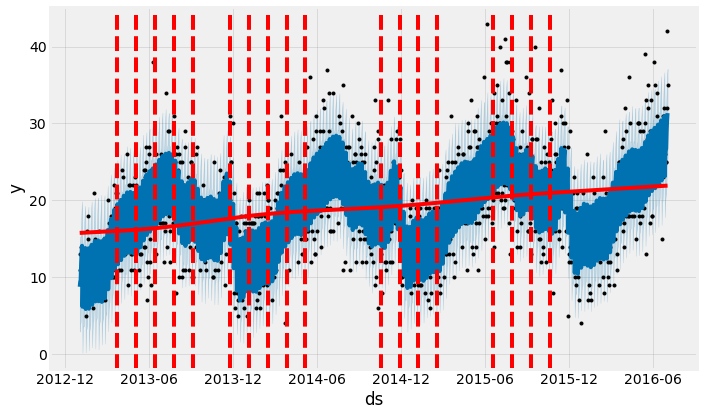

In [39]:
with suppress_stdout_stderr():

    # use the mcmc_samples functionality
    m1 = Prophet(mcmc_samples=300) 

    # fit the model
    m1.fit(x_train) 

    future = m1.make_future_dataframe(periods=0) 

    forecast = m1.predict(future)

    fig = m1.plot(forecast)
    a = add_changepoints_to_plot(fig.gca(), m1, forecast)

    plt.show()

 Examine the magnitude of the rate change at each changepoint, for the two approaches: without mcmc and with mcmc (Bayesian inference).

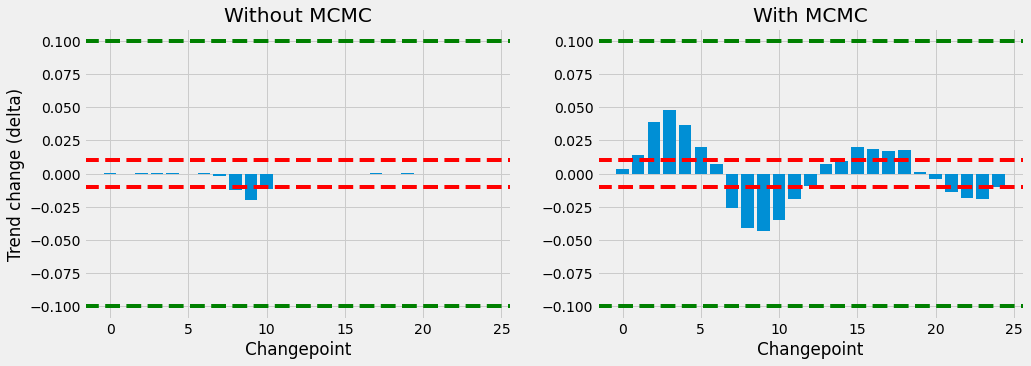

In [40]:
fig = plt.figure(figsize=(15, 5))

ax = fig.add_subplot(121)
ax.bar(np.arange(25), np.nanmean(m0.params['delta'], axis=0))
ax.set_title('Without MCMC')
ax.set_xlabel('Changepoint')
ax.set_ylabel('Trend change (delta)')
ax.axhline(y=0.01, color='r', ls='--')
ax.axhline(y=-0.01, color='r', ls='--')
ax.axhline(y=0.1, color='g', ls='--')
ax.axhline(y=-0.1, color='g', ls='--')

ax = fig.add_subplot(122)
ax.bar(np.arange(25), np.nanmean(m1.params['delta'], axis=0))
ax.set_xlabel('Changepoint')
ax.axhline(y=0.01, color='r', ls='--')
ax.axhline(y=-0.01, color='r', ls='--')
ax.axhline(y=0.1, color='g', ls='--')
ax.axhline(y=-0.1, color='g', ls='--')
ax.set_title('With MCMC');

**Adjusting trend flexibility**

If the trend changes underfit (not enough flexibility), one can adjust the strength of the sparse prior using the input argument `changepoint_prior_scale`. By default, this parameter is set to 0.05. According to <a href='https://facebook.github.io/prophet/docs/trend_changepoints.html#automatic-changepoint-detection-in-prophet'>Prophet documentation</a>, increasing it will make the trend more flexible:

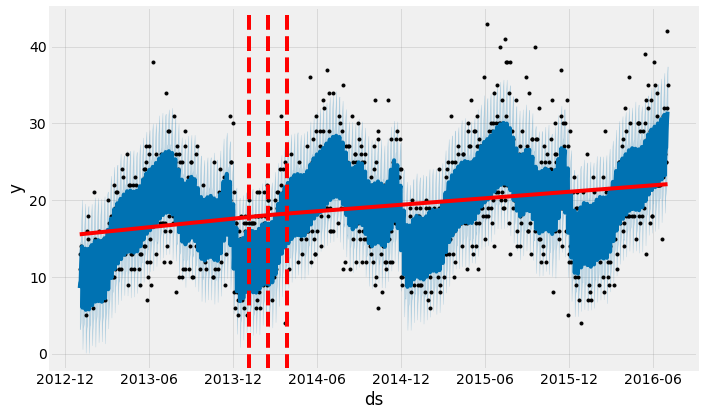

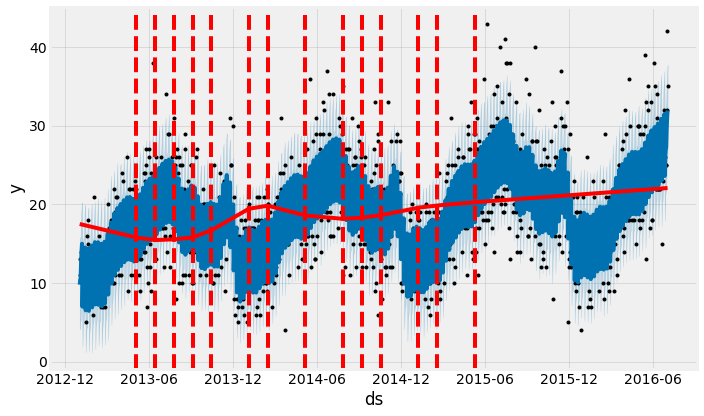

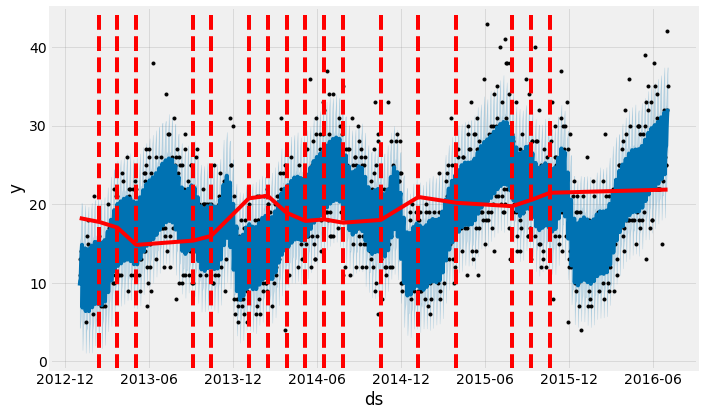

In [41]:
for thresh in [0.05, 1, 5]:
    with suppress_stdout_stderr():

        # use the mcmc_samples functionality
        m1 = Prophet(changepoint_prior_scale=thresh) 

        # fit the model
        m1.fit(x_train) 

        future = m1.make_future_dataframe(periods=0) 

        forecast = m1.predict(future)

        fig = m1.plot(forecast)
        a = add_changepoints_to_plot(fig.gca(), m1, forecast)

        plt.show()

**Multiplicative seasonality**

Initial log joint probability = -30.6342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2320.25    0.00192189       167.542           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     195       2320.39   1.14605e-07       71.4311      0.3614           1      245   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


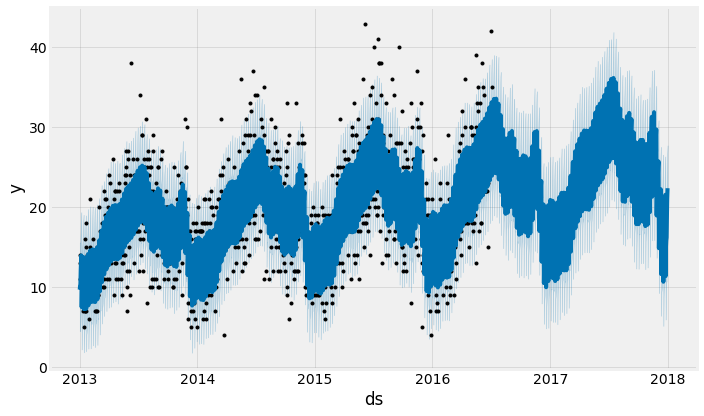

In [42]:
# intantiate a model with default parameters
m_mul = Prophet(seasonality_mode='multiplicative') 

# fit the model
m_mul.fit(x_train) 

# get a suitable dataframe that extends into the future a specified number of days
# forecast will contain the prediction for all x_train dates + the prediction for 
#`periods` number of days into the future
future = m_mul.make_future_dataframe(periods=len(X_eval)) 

# in-sample predictions as well as out of sample predictions (if periods above was different than 0)
forecast_mul = m_mul.predict(future)

m_add.plot(forecast_mul)

plt.show()

It's difficult to judge with the naked eye is there's a difference in results. I proceed with formal model evaluation.

**Model evaluation**

In [43]:
# calculate MAE between expected and predicted values for december
y_true = X_eval.values

y_pred = forecast_add[-len(X_eval):]['yhat'].values
mae_add = mean_absolute_error(y_true, y_pred)

y_pred = forecast_mul[-len(X_eval):]['yhat'].values
mae_mult = mean_absolute_error(y_true, y_pred)

new_result = pd.DataFrame.from_dict({'method':['additive', 'multiplicative'], 'mae': [mae_add, mae_mult]})
new_result.index = ['Prophet default', 'Prophet default']
results_df = results_df.append(new_result)
results_df

,method,mae
triple exponential smoothing,additive,5.411132
Prophet default,additive,4.071613
Prophet default,multiplicative,4.082487


Additive seasonality for Prophet is marginally better.  

Prophet is better than triple smoothing.

The good thing about MAE is that it has the same unit of measurement as the initial data.  

Our dataset (sales) ranges between 0 and 40 (more or less). And we have a MAE of 4. That is, 10% of the amplitude of our 'signal'. This seems like it's not small.  

I'll try non-default parameter values for Prophet. First, let's see what parameters we can set for this model.

In [44]:
# uncomment the line below to see what parameters we can set for the Prophet instance
?Prophet

**Grid search for the best parameters**

- make some combinations of parameters to try in order to find the best model parameters  
- use cross-validation to obtain results for each parameters combination  

Parameters to try:

- *seasonality_prior_scale:*   
    Parameter modulating the strength of the
    seasonality model. Larger values allow the model to fit larger seasonal
    fluctuations, smaller values dampen the seasonality. Can be specified
    for individual seasonalities using add_seasonality
- *seasonality_mode:*   
    'additive' (default) or 'multiplicative'.  
    I did it 'by hand' earlier, but could have done it as part of the grid search here
- *changepoint_prior_scale:*   
    Parameter modulating the flexibility of the
    automatic changepoint selection. Large values will allow many
    changepoints, small values will allow few changepoints.  
    By default, Prophet will estimate 25 changepoints. 

<a href='https://facebook.github.io/prophet/docs/diagnostics.html#cross-validation'>Prophet documentation</a> advises on which parameter should, may or should not be tuned.

In [45]:
# parameters that can potentially improve the performance of our model
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.05, 0.5, 1.0, 5.0],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0, 20.0],
    'seasonality_mode': ['additive', 'multiplicative'],
}

# generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

# check some of our combinations of parameters
all_params[:2]

[{'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 0.01,
  'seasonality_mode': 'additive'},
 {'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 0.01,
  'seasonality_mode': 'multiplicative'}]

Read about how cross-validation is implemented in Prophet <a href='https://facebook.github.io/prophet/docs/diagnostics.html#cross-validation'>here</a>. Short overview:  
- select cutoff points in the history; for each of them fit the model using data only up to that cutoff point  
- cross validation  can be done automatically for a range of historical cutoffs using the cross_validation function
- we specify the forecast horizon (`horizon`), and then optionally the size of the initial training period (`initial`) and the spacing between cutoff dates (`period`). By default, the initial training period is set to three times the horizon, and cutoffs are made every half a horizon.

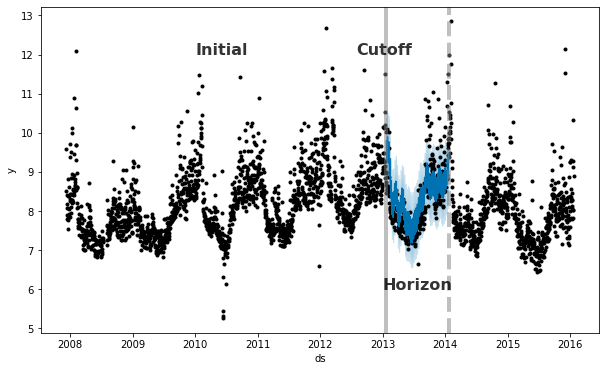
*image reproduced from <a href='https://facebook.github.io/prophet/docs/diagnostics.html#cross-validation'>Prophet documentation</a>*

- start with initial training period of 2 years, so we have 2 times the amount of data take by the largest season (2 years) for training (2 x 366 days, to be sure)
- predict for one year (horizon = 365 days)

In [46]:
rmses = [] 
maes = []

with suppress_stdout_stderr():
    for params in all_params:
        m = Prophet(**params).fit(x_train);
        df_cv = cross_validation(m, initial = '732 days', period = '365 days', horizon='365 days', parallel="processes")  
        df_p = performance_metrics(df_cv, rolling_window=1)
        rmses.append(df_p['rmse'].values[0])
        maes.append(df_p['mae'].values[0])

In [47]:
# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
tuning_results['mae'] = maes
tuning_results

,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,rmse,mae
0,0.001,0.01,additive,4.991271,3.915146
1,0.001,0.01,multiplicative,5.651784,4.477061
2,0.001,0.10,additive,4.813979,3.764343
3,0.001,0.10,multiplicative,4.742689,3.728384
4,0.001,1.00,additive,4.813069,3.763385
5,0.001,1.00,multiplicative,4.740914,3.730020
6,0.001,10.00,additive,4.813039,3.763344
7,0.001,10.00,multiplicative,4.740904,3.730045
8,0.001,20.00,additive,4.813039,3.763344
9,0.001,20.00,multiplicative,4.740904,3.730045


In [48]:
# Python
best_params = all_params[np.argmin(rmses)]
print(best_params)

best_params = all_params[np.argmin(maes)]
print(best_params)

{'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}
{'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative'}


In [49]:
new_result = pd.DataFrame.from_dict({'method':['multiplicative'], 'mae': [min(maes)]})
new_result.index = ['Prophet grid search']
results_df = results_df.append(new_result)
results_df

,method,mae
triple exponential smoothing,additive,5.411132
Prophet default,additive,4.071613
Prophet default,multiplicative,4.082487
Prophet grid search,multiplicative,3.692950


Even after finding the best parameters, the results (mae) did not improve that much.  

I'll have a closer look at predictions to try to see what could be improved.

In [50]:
# retrain with the best parameters
best_m = Prophet(**best_params).fit(x_train);
future = best_m.make_future_dataframe(periods=0) 
forecast = best_m.predict(future)

# examine a short portion of the data
xfor = forecast[['ds', 'yhat', 'yhat_upper', 'yhat_lower']][-60:]
xfor.head(10)

Initial log joint probability = -30.6342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       2314.52   0.000946875       175.182   1.102e-05       0.001      158  LS failed, Hessian reset 
      99       2314.56   0.000422993        110.23           1           1      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       2314.78   4.45842e-05       56.4404   7.937e-07       0.001      216  LS failed, Hessian reset 
     165       2314.93   0.000287976       84.0789   2.948e-06       0.001      319  LS failed, Hessian reset 
     199       2314.96   2.92364e-05        73.944      0.2862           1      364   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     239       2314.97   2.18855e-05       70.5928   3.358e-07       0.001      446  LS failed, Hessian reset 
     280       2314.97   2.67286e-07       87.1874      0.7222   

,ds,yhat,yhat_upper,yhat_lower
1220,2016-05-05,22.365473,27.686733,17.076134
1221,2016-05-06,24.922592,30.461292,19.486032
1222,2016-05-07,26.641193,32.391481,21.225799
1223,2016-05-08,27.815560,33.133328,22.186742
1224,2016-05-09,18.828738,24.098738,13.598430
1225,2016-05-10,21.985711,27.598743,16.487771
1226,2016-05-11,22.771685,28.351699,17.435401
1227,2016-05-12,23.097082,28.605203,17.439768
1228,2016-05-13,25.721046,31.060711,20.429051
1229,2016-05-14,27.497461,32.646538,22.193035


In [51]:
# combine the forecast dataframe with the original test data
xfor = pd.merge(left = xfor, right = x_train, on = 'ds', how = 'left')

<AxesSubplot:>

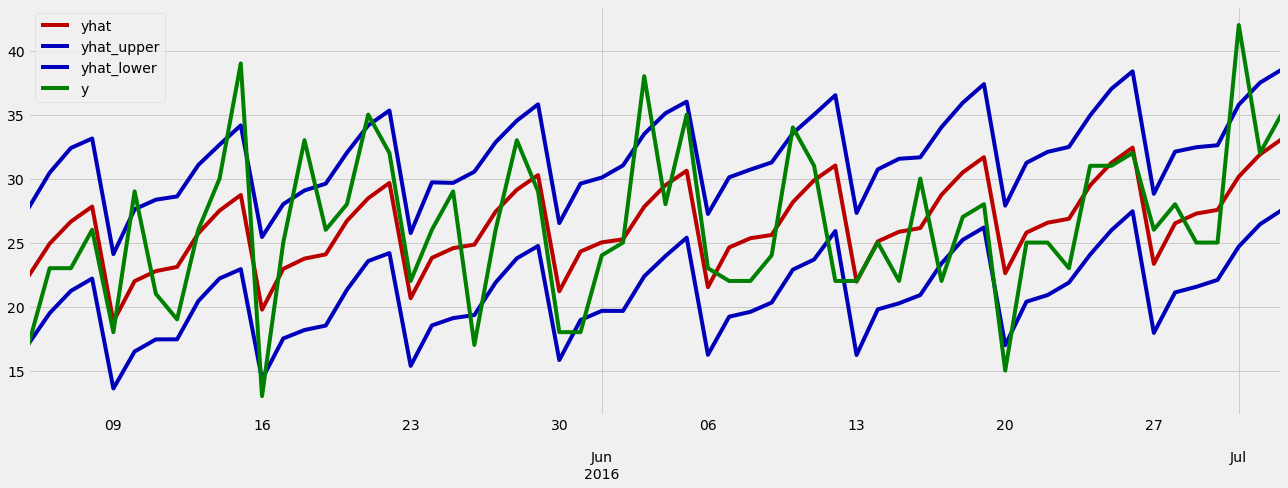

In [52]:
colors = ['#BB0000' , '#0000BB', '#0000BB', 'green']

xfor['ds'] = pd.to_datetime(xfor['ds'])
xfor.set_index('ds').plot(color = colors, figsize=(20, 7), xlabel = '')

Observations:  
- the model understates the magnitude of fluctuations in the data
- confidence intervals are wide (a width of 10 for a data that oscillates mainly between 10 and 50 seems quite broad).

### Neural Prophet

<a href='https://neuralprophet.com/html/index.html'>Neural Prophet documentation</a>

In [53]:
!pip install neuralprophet

     |████████████████████████████████| 73 kB 984 kB/s             


In [54]:
from neuralprophet import NeuralProphet
pd.options.mode.chained_assignment = None

import math
import torch
torch.pi = math.pi

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.922% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 116


  0%|          | 0/255 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.47E-02, min: 1.22E+00


  0%|          | 0/255 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.96E-02, min: 1.84E+00


  0%|          | 0/255 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.96E-02, min: 1.56E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.13E-02
Epoch[116/116]: 100%|██████████| 116/116 [00:08<00:00, 13.14it/s, SmoothL1Loss=0.0136, MAE=3.36, RMSE=4.25, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.922% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


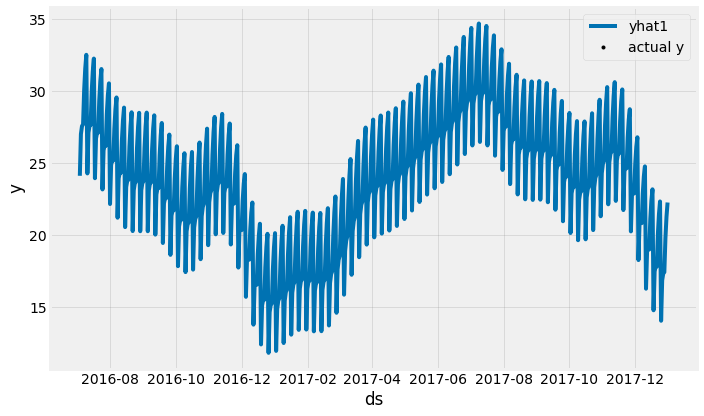

In [55]:
m_neural = NeuralProphet()

metrics = m_neural.fit(x_train, freq="D")

# predict one year into the future 
future = m_neural.make_future_dataframe(x_train, periods=len(X_eval)) 

# in-sample predictions as well as out of sample predictions (if periods above was different than 0)
forecast_neural = m_neural.predict(future)

m_neural.plot(forecast_neural)

plt.show()

In [56]:
forecast_neural

,ds,y,yhat1,residual1,trend,season_yearly,season_weekly
0,2016-07-04,None,24.126541,None,22.242235,6.301673,-4.417367
1,2016-07-05,None,27.024801,None,22.248207,6.346824,-1.570229
2,2016-07-06,None,27.574265,None,22.254177,6.383471,-1.063384
3,2016-07-07,None,27.698044,None,22.260147,6.411140,-0.973242
4,2016-07-08,None,30.062336,None,22.266119,6.429406,1.366811
...,...,...,...,...,...,...,...
541,2017-12-27,None,17.354740,None,25.472387,-7.054262,-1.063384
542,2017-12-28,None,17.436144,None,25.478357,-7.068972,-0.973242
543,2017-12-29,None,19.781258,None,25.484329,-7.069882,1.366811
544,2017-12-30,None,21.280031,None,25.490299,-7.057850,2.847580
